# Detecting COVID-19 in X-ray images

### Description:

- __Covid-19 x_ray images source - https://github.com/ieee8023/covid-chestxray-dataset__
- __Normal x_ray images source - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia__
    
__Data__: The Dataset used here contains x-ray images from two sources. 
    The COVID-19 x-ray images are used from the above github repo, the images are collected by *Dr. Joseph Cohen* and 
    the normal x-ray images are used from *Chest X-Ray Images (Pneumonia)* dataset by Paul Mooney

- __All the x-ray images used have *Anterior-Posterior* view__

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from GradCAM.gradcam import GradCAM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Reading Data

In [6]:
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[1]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [7]:
dataset = pd.DataFrame()
dataset['data'] = data
dataset['labels'] = labels

#seperating covid postive and normal patient data
covid = dataset[dataset['labels'] == 'covid']
normal = dataset[dataset['labels'] == 'normal']

In [8]:
covid.head(5)

data labels
0  [[[133, 133, 133], [122, 122, 122], [115, 115,...  covid
1  [[[51, 51, 51], [52, 52, 52], [50, 50, 50], [5...  covid
2  [[[7, 7, 7], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...  covid
3  [[[44, 42, 43], [53, 51, 52], [57, 55, 56], [5...  covid
4  [[[104, 104, 104], [102, 102, 102], [102, 102,...  covid

In [9]:
normal.head(5)

data  labels
180  [[[6, 6, 6], [4, 4, 4], [20, 20, 20], [27, 27,...  normal
181  [[[22, 22, 22], [1, 1, 1], [0, 0, 0], [0, 0, 0...  normal
182  [[[60, 60, 60], [57, 57, 57], [51, 51, 51], [5...  normal
183  [[[111, 111, 111], [112, 112, 112], [108, 108,...  normal
184  [[[9, 9, 9], [13, 13, 13], [22, 22, 22], [30, ...  normal

There are 180 x-ray images of normal patients and 180 x-ray images of Covid-19 positive patients
---------------------------------------------------------


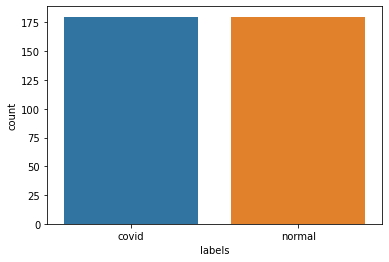

In [10]:
print("There are {} x-ray images of normal patients and {} x-ray images of Covid-19 positive patients".format(len(normal), len(covid)))
print('-'*57)
ax = sns.countplot(x="labels", data=dataset)

- As we can see the dataset is perfectly balanced there are 180 images for each class

## Visualizing Data

__Normal Patients__

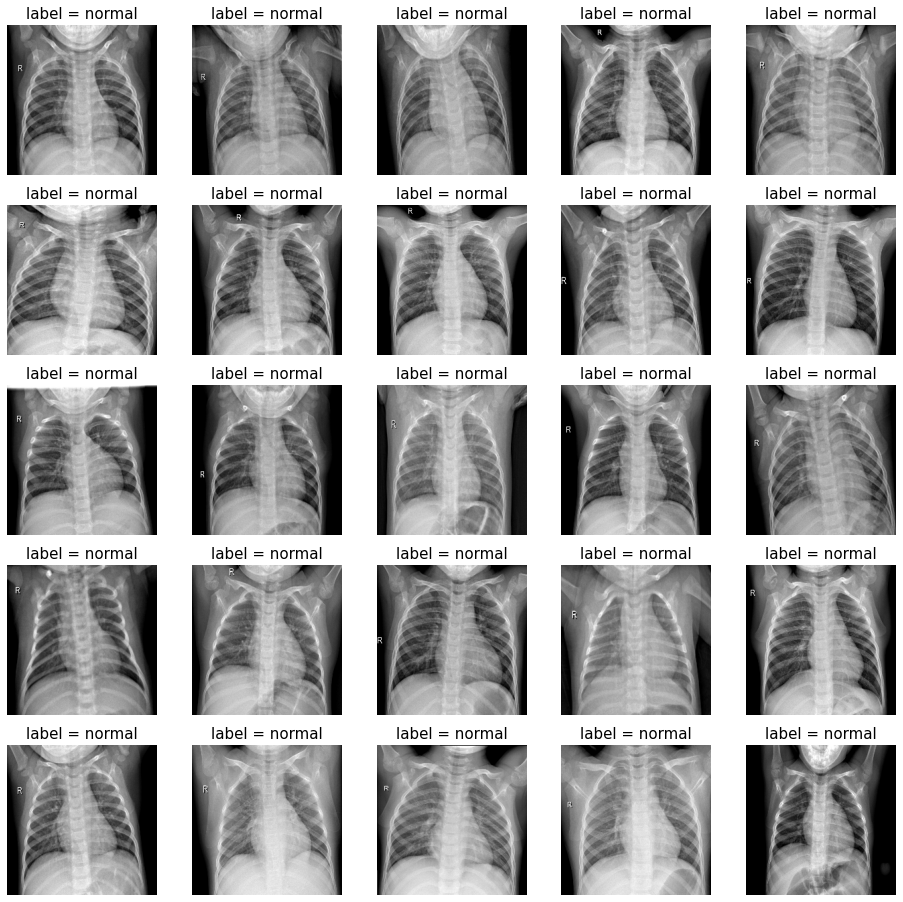

In [11]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (16,16))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(normal.data.values[i])
    axes[i].set_title('label = {}'.format(normal.labels.values[i]), fontsize = 15)
    axes[i].axis('off')

__Covid Positive Patients__

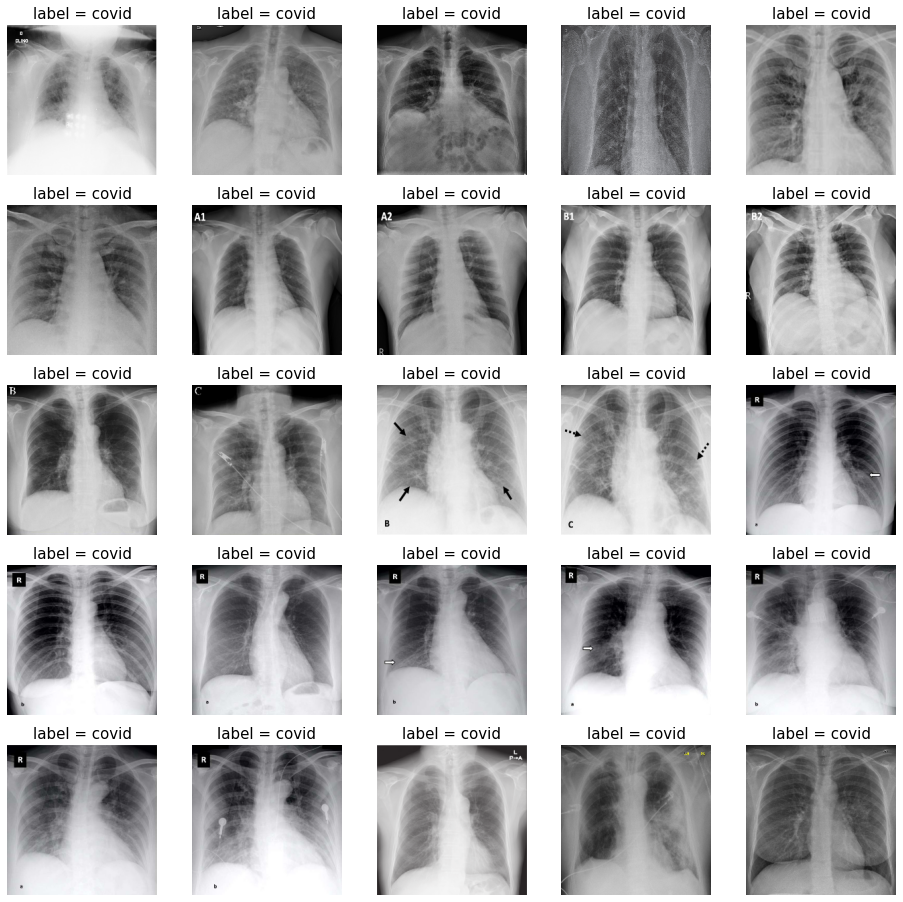

In [12]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (16,16))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(covid.data.values[i])
    axes[i].set_title('label = {}'.format(covid.labels.values[i]), fontsize = 15)
    axes[i].axis('off')

## Building Model

In [104]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = ['normal','covid']
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    print('Accuracy: ', accuracy_score(test_y,predict_y))
    print('Recall: ', recall_score(test_y,predict_y))
    print('Precision: ', precision_score(test_y,predict_y))
    print('Specificity: ', C[1, 1] / (C[1, 0] + C[1, 1]))
    print('F1 score: ', f1_score(test_y, predict_y))
    
    plt.show()

In [14]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(dataset.data.to_list()) / 255.0
labels = np.array(dataset.labels)

In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [16]:
# splitting the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

In [17]:
# initialize the training data augmentation object
datagen = ImageDataGenerator(rotation_range=15,
                             zoom_range = 0.2,
                             fill_mode="nearest")

In [18]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [22]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [24]:
# compile our model
opt = Adam(lr=0.001, decay=0.001 / 25)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
batch_size = 20
epoch = 30

In [27]:
train_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                  steps_per_epoch=len(x_train) // batch_size,
                                  validation_data=(x_test, y_test), validation_steps=len(x_test) // batch_size, 
                                  epochs=epoch)

Epoch 1/30
12/12 [==============================] - 40s 3s/step - loss: 0.7472 - acc: 0.4957 - val_loss: 0.6025 - val_acc: 0.8704
Epoch 2/30
12/12 [==============================] - 28s 2s/step - loss: 0.5604 - acc: 0.7759 - val_loss: 0.5213 - val_acc: 0.8981
Epoch 3/30
12/12 [==============================] - 24s 2s/step - loss: 0.5398 - acc: 0.7931 - val_loss: 0.4445 - val_acc: 0.9259
Epoch 4/30
12/12 [==============================] - 24s 2s/step - loss: 0.4302 - acc: 0.8621 - val_loss: 0.4147 - val_acc: 0.8426
Epoch 5/30
12/12 [==============================] - 24s 2s/step - loss: 0.4353 - acc: 0.8103 - val_loss: 0.3324 - val_acc: 0.9352
Epoch 6/30
12/12 [==============================] - 25s 2s/step - loss: 0.3572 - acc: 0.8833 - val_loss: 0.3219 - val_acc: 0.8981
Epoch 7/30
12/12 [==============================] - 24s 2s/step - loss: 0.3269 - acc: 0.9018 - val_loss: 0.2564 - val_acc: 0.9444
Epoch 8/30
12/12 [==============================] - 24s 2s/step - loss: 0.3679 - acc: 0.85

In [28]:
# make predictions on the testing set
predIdxs = model.predict(x_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

Accuracy:  0.9814814814814815
Recall:  0.9814814814814815
Precision:  0.9814814814814815
Specificity:  0.9814814814814815
F1 score:  0.9814814814814815


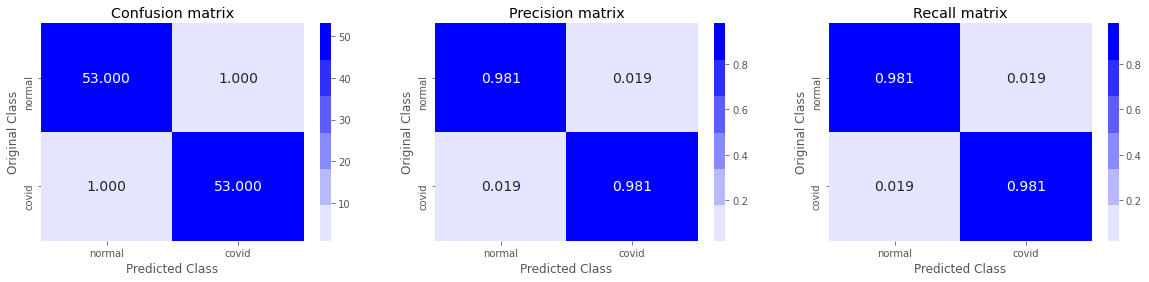

In [105]:
plot_confusion_matrix(y_test.argmax(axis=1), predIdxs)

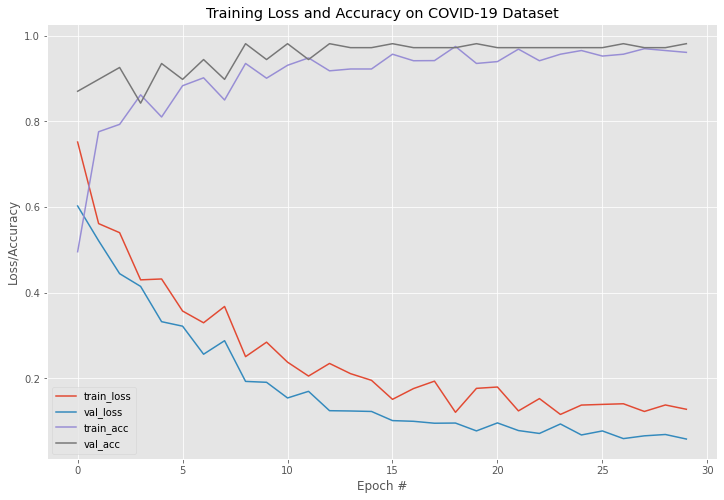

In [30]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoch), train_model.history["loss"], label="train_loss")
plt.plot(np.arange(epoch), train_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(epoch), train_model.history["acc"], label="train_acc")
plt.plot(np.arange(epoch), train_model.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

- As we can see the Model has a very high accuracy, precision and recall score
- Except 2 images All the images were classified perfectly